<a href="https://colab.research.google.com/github/Zeroflip64/Study_projects/blob/main/hotels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Описание проекта


Заказчик этого исследования — сеть отелей «Как в гостях».
Сеть отелей 
Цель необходимо  разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Шаг 1. Загрузим необходимые библиотеки и данные. ENG : Step 1. Download the necessary libraries and data.

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
!pip install catboost -q

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.metrics import f1_score,accuracy_score,recall_score,confusion_matrix,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df=pd.read_csv('/content/drive/MyDrive/учеба/project/yandex/Сборный проект/hotel_train.csv')
test=pd.read_csv('/content/drive/MyDrive/учеба/project/yandex/Сборный проект/hotel_test.csv')

In [6]:
display(df.head())
display(test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [7]:
print('Размер данных для обучения',df.shape)
print('Размер тестовых данных',test.shape)

Размер данных для обучения (65229, 25)
Размер тестовых данных (32412, 25)


<Axes: >

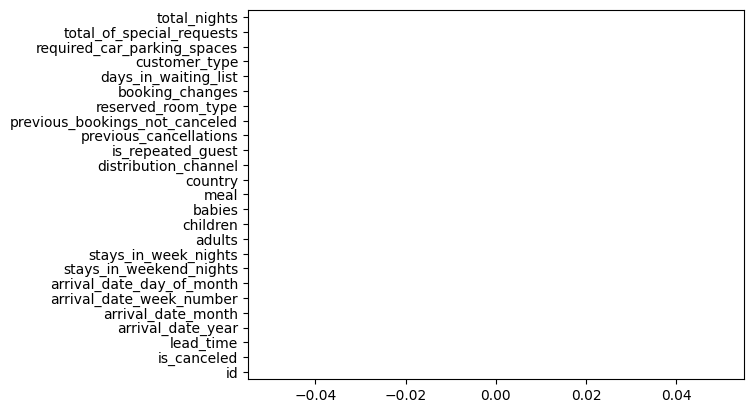

In [8]:
df.isna().sum().plot(kind='barh')

<Axes: >

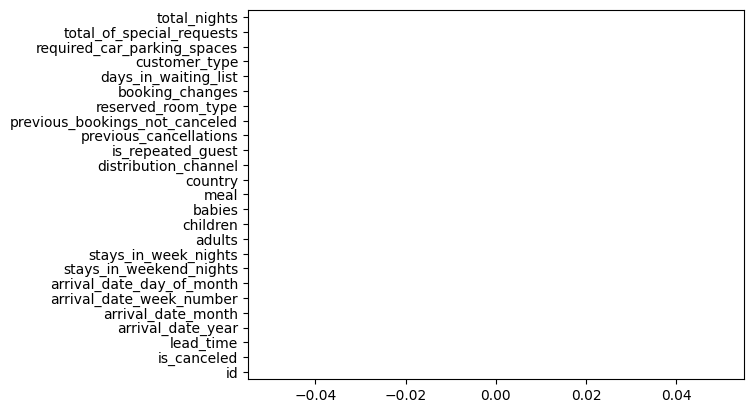

In [9]:
test.isna().sum().plot(kind='barh')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [12]:
df.duplicated().sum()

0

In [13]:
test.duplicated().sum()

0

In [14]:
df.shape

(65229, 25)

In [15]:
df=df.drop('id',axis=1)
test=test.drop('id',axis=1)

In [16]:
#df=df.drop_duplicates().reset_index(drop=True)

In [17]:
df.head(1)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,...,0,0,0,A,0,0,Transient,0,0,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65229 non-null  int64  
 1   lead_time                       65229 non-null  float64
 2   arrival_date_year               65229 non-null  int64  
 3   arrival_date_month              65229 non-null  object 
 4   arrival_date_week_number        65229 non-null  int64  
 5   arrival_date_day_of_month       65229 non-null  int64  
 6   stays_in_weekend_nights         65229 non-null  int64  
 7   stays_in_week_nights            65229 non-null  int64  
 8   adults                          65229 non-null  float64
 9   children                        65229 non-null  float64
 10  babies                          65229 non-null  float64
 11  meal                            65229 non-null  object 
 12  country                         

#### Функции / Functions

Создадим несколько функции для объединения нужных признаков / Let's create several functions to combine the necessary features

In [19]:
def season(df): # Функция для создания признака сезонности
  month=df['arrival_date_month']
  
  if month in ['January','February','December']:
    return 1
  elif month in ['March','April','May']:
    return 2
  elif month in ['June','July','August']:
    return 3
  elif month in ['September','October','November']:
    return 4    

In [20]:
def how_long(df): # фунция которая обьеденяет за сколько было забранированн номер
  days=df['lead_time']
  if days<=30:
    return 'month'
  elif 30 < days<=90:
    return 'quarter'
  elif 90<days<=120:
    return 'half_year'
  elif days>120:
    return 'over_half'

#### Обработка данных / Data processing

Добавим колонку где объединены типы клиентов и как они бронировали номера / Let's add a column where the types of customers are combined and how they booked rooms

In [21]:
df['type']=df['distribution_channel']+'_'+df['customer_type']

test['type']=test['distribution_channel']+'_'+test['customer_type']

Добавляем новые колонки где добавляем цифровые обозначения типов комнат ,вариантов обедов.
Так же добавили стобцы которые обозначают сезон и как давно сделали заказ. / We add new columns where we add digital designations of room types, lunch options.
We also added columns that indicate the season and how long ago the order was made.

In [22]:
df['how_long']=df.apply(how_long,axis=1)
df['season']=df.apply(season,axis=1)

test['how_long']=test.apply(how_long,axis=1)
test['season']=test.apply(season,axis=1)

Добавили так же цифровое обозначение давности заказа и так же добавили колонку с ощим количеством людей в бронировании. / We also added a digital designation of the prescription of the order and also added a column with the total number of people in the booking.

In [23]:

df['count_of_people']=df['children']+df['babies']+df['adults']


test['count_of_people']=test['children']+test['babies']+test['adults']

In [24]:
df.loc[df['adults']==0,'children'].value_counts()

2.0    141
0.0     15
3.0      8
1.0      2
Name: children, dtype: int64

In [25]:
df=df.loc[df['adults']!=0]

In [26]:
df.shape

(65063, 28)

In [27]:

df['true']=df['total_nights']==(df['stays_in_week_nights']+df['stays_in_weekend_nights'])
df.loc[df['true']==False]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,type,how_long,season,count_of_people,true


In [28]:

test['true']=test['total_nights']==(test['stays_in_week_nights']+test['stays_in_weekend_nights'])
test.loc[test['true']==False]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,type,how_long,season,count_of_people,true


Удаляем не нужные колонки / Drop features

In [29]:
df=df.drop(['arrival_date_month','distribution_channel','customer_type','stays_in_week_nights','stays_in_weekend_nights','true'],axis=1)

test=test.drop(['arrival_date_month','distribution_channel','customer_type','stays_in_week_nights','stays_in_weekend_nights','true'],axis=1)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65063 entries, 0 to 65228
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65063 non-null  int64  
 1   lead_time                       65063 non-null  float64
 2   arrival_date_year               65063 non-null  int64  
 3   arrival_date_week_number        65063 non-null  int64  
 4   arrival_date_day_of_month       65063 non-null  int64  
 5   adults                          65063 non-null  float64
 6   children                        65063 non-null  float64
 7   babies                          65063 non-null  float64
 8   meal                            65063 non-null  object 
 9   country                         65063 non-null  object 
 10  is_repeated_guest               65063 non-null  int64  
 11  previous_cancellations          65063 non-null  int64  
 12  previous_bookings_not_canceled  

In [31]:
print(df.shape)
print(test.shape)

(65063, 23)
(32412, 23)


In [32]:
df.reserved_room_type=df.reserved_room_type.str.strip()# Удалилм длинные пропуски после обозначения типов комнат
test.reserved_room_type=test.reserved_room_type.str.strip()

0    0.631188
1    0.368812
Name: is_canceled, dtype: float64

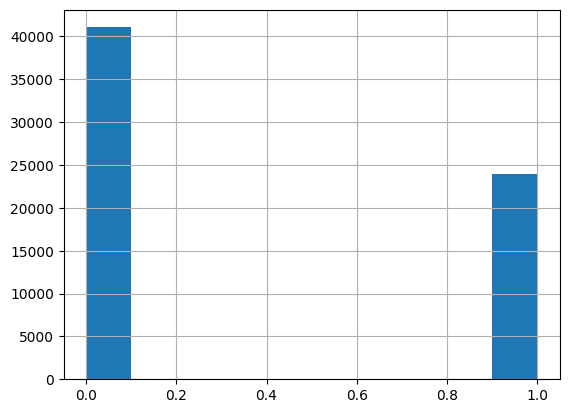

In [33]:
df['is_canceled'].hist()# мы видим несбалансированость целевого признака
df['is_canceled'].value_counts(normalize=True)

### Шаг 2. Предобработка и исследовательский анализ данных / Step 2. Preprocessing and Exploratory data analysis

**Переведем признаки в нужный формат**

Let's change the features type 

In [34]:
object_columns=['arrival_date_year','adults','children','babies','is_repeated_guest','required_car_parking_spaces','season']
for i in object_columns:
  df[i]=df[i].astype('object')
  test[i]=test[i].astype('object')

In [35]:
num_columns=[i for i in df.columns if df[i].dtypes!='object']
object_columns=[i for i in df.columns if df[i].dtypes=='object']


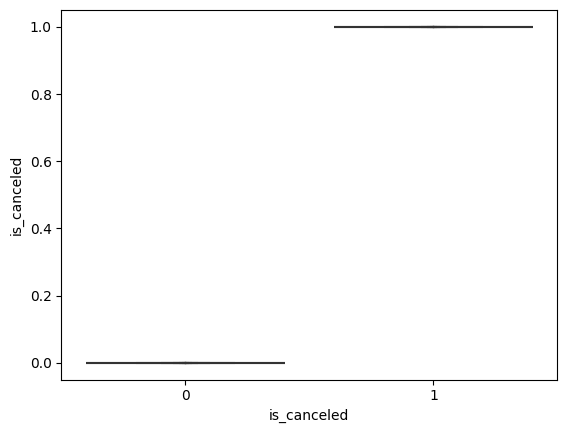

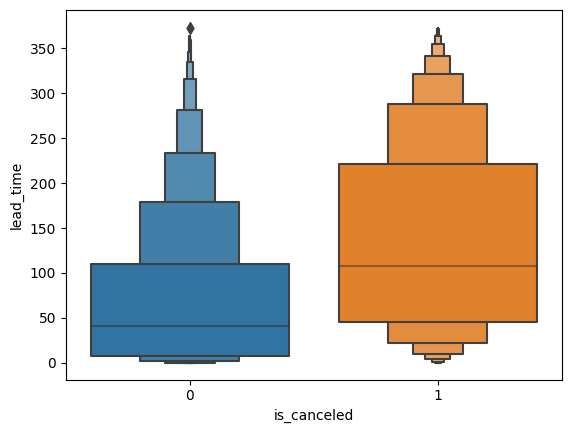

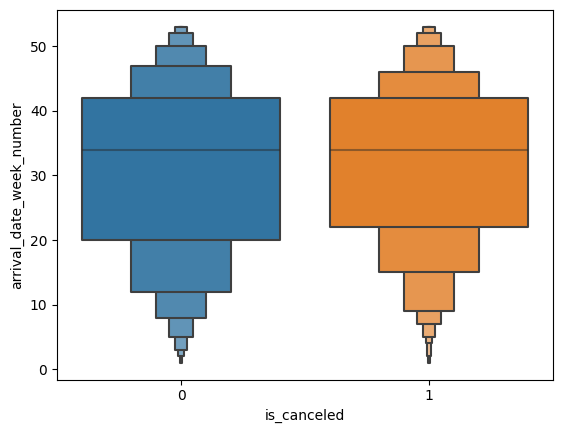

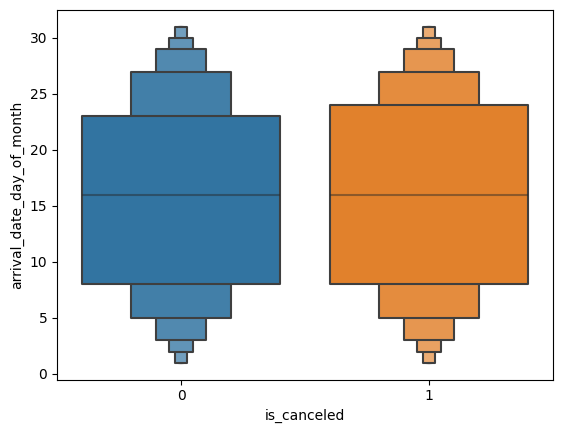

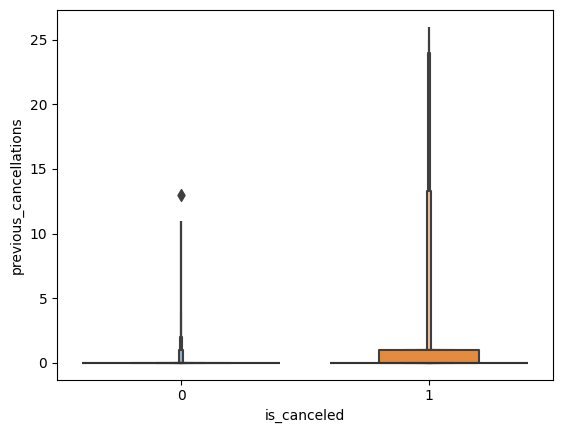

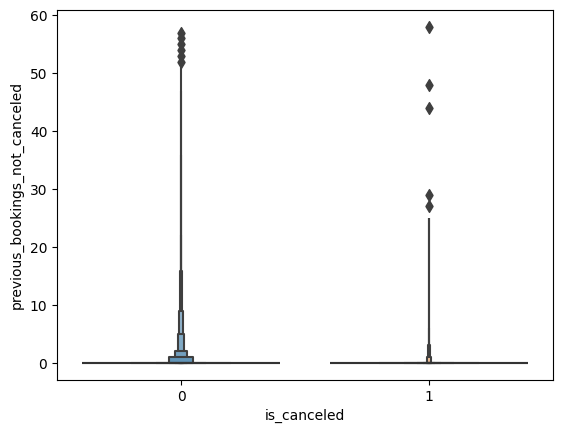

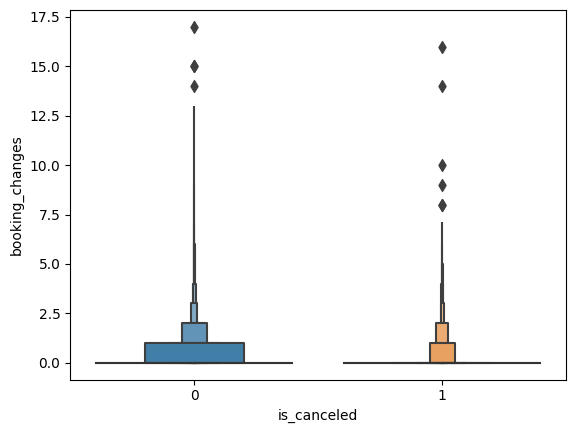

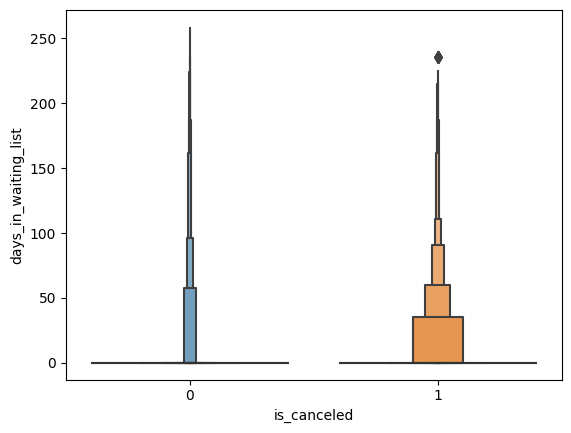

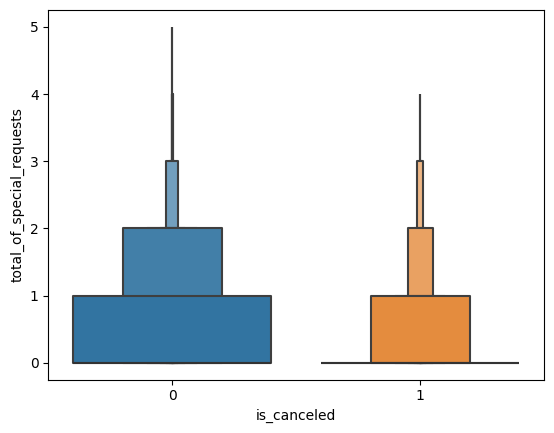

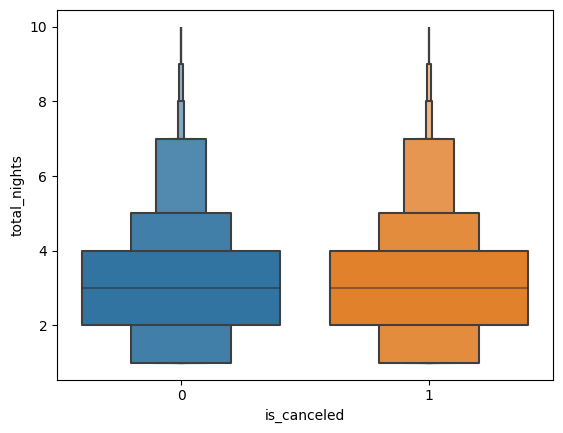

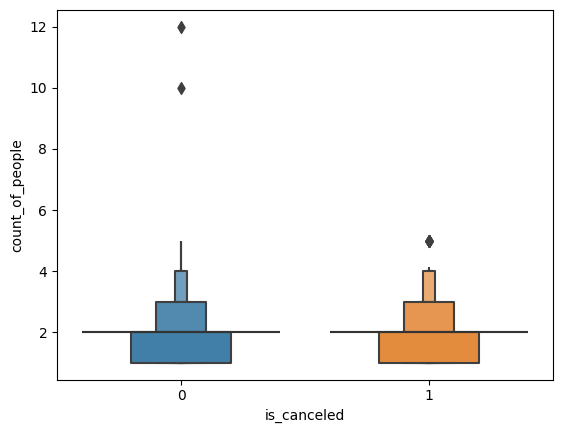

In [36]:
for i in num_columns:
  sns.boxenplot(x='is_canceled',y=i,data=df)
  plt.show()

Мы видим достаточно много выбросов почистим наши данные. / We see quite a lot of outliers, let's clean up our data.

In [37]:
df=df.loc[df['previous_cancellations']<10]
df=df.loc[df['booking_changes']<7]
df=df.loc[df['count_of_people']<5]
df=df.loc[df['days_in_waiting_list']<150]

df=df.loc[df['previous_bookings_not_canceled']<6]

In [38]:
countries=pd.Series(df['country'].value_counts())
good_country=countries.loc[countries>10].index
df=df.loc[df['country'].isin(good_country)]
test=test.loc[test['country'].isin(good_country)]

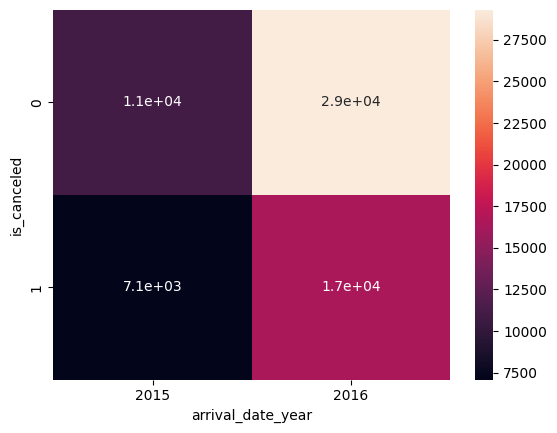

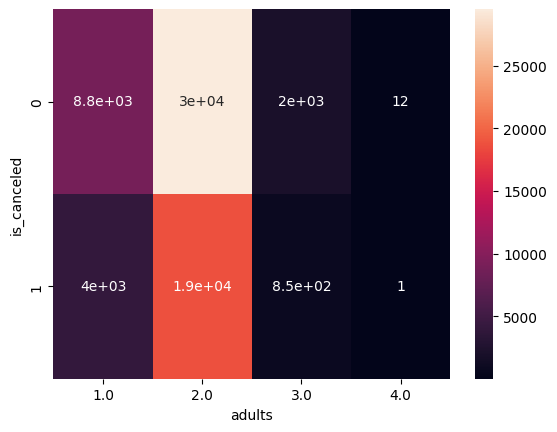

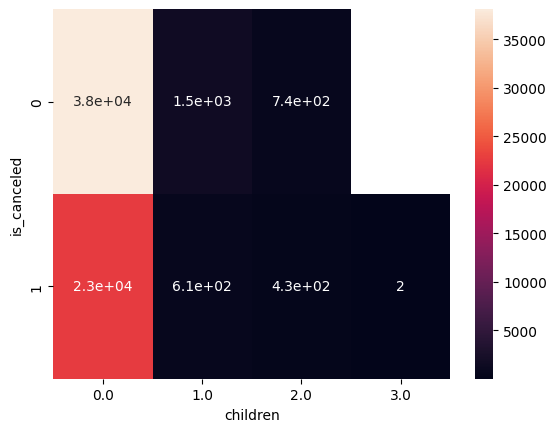

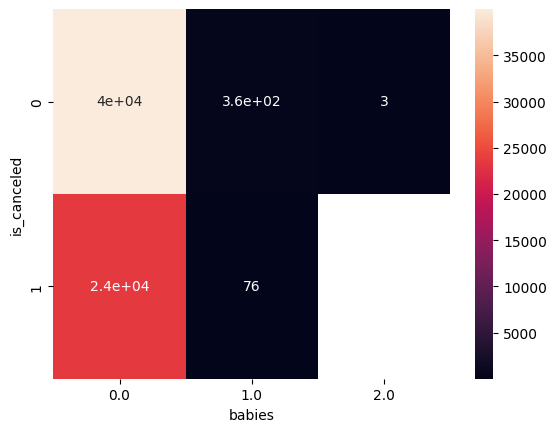

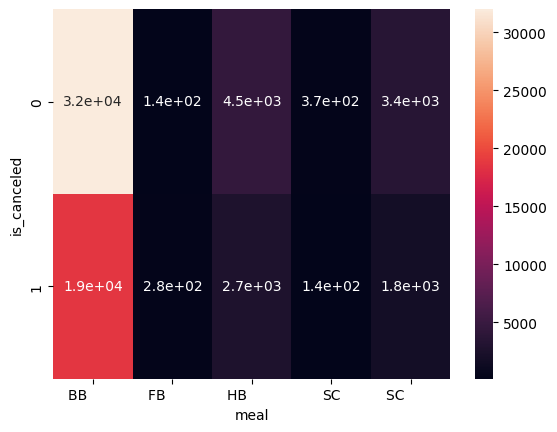

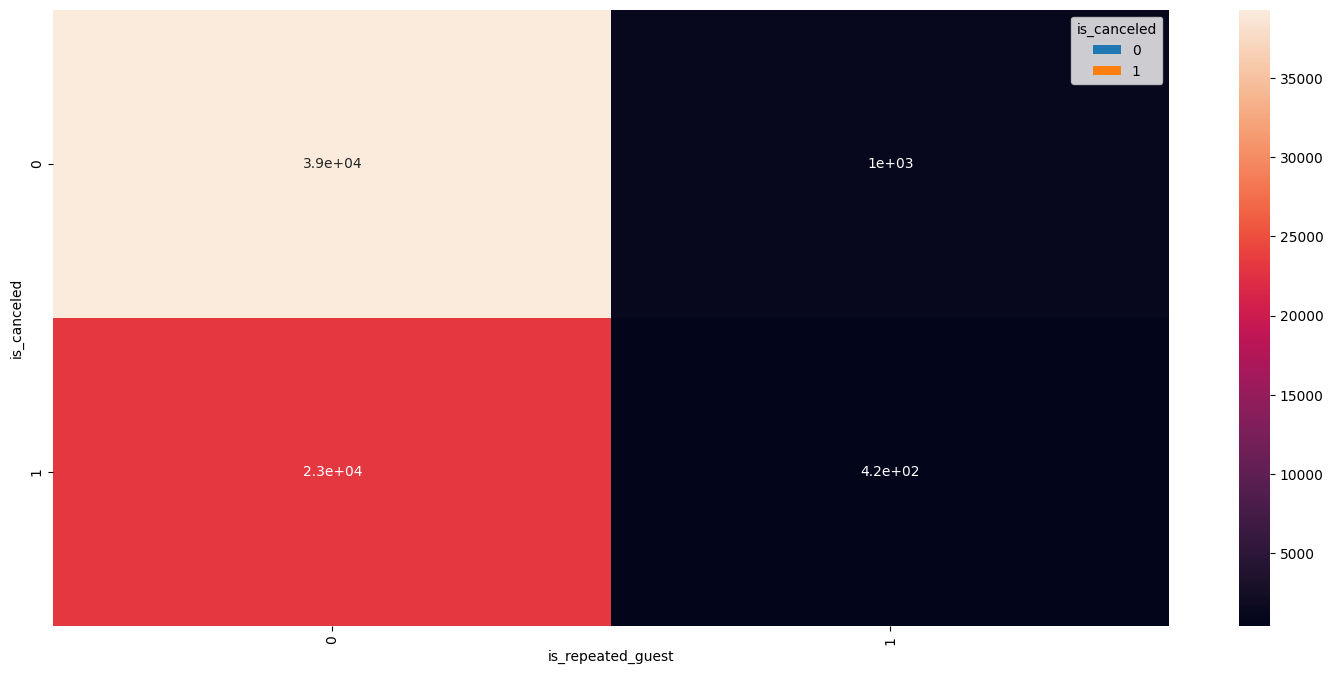

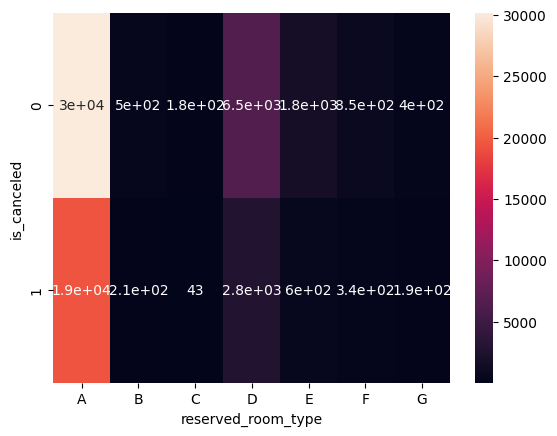

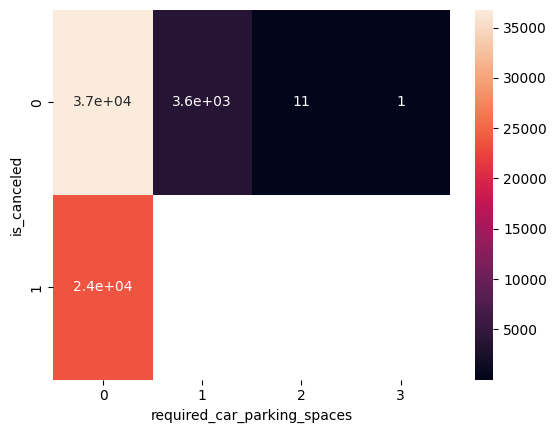

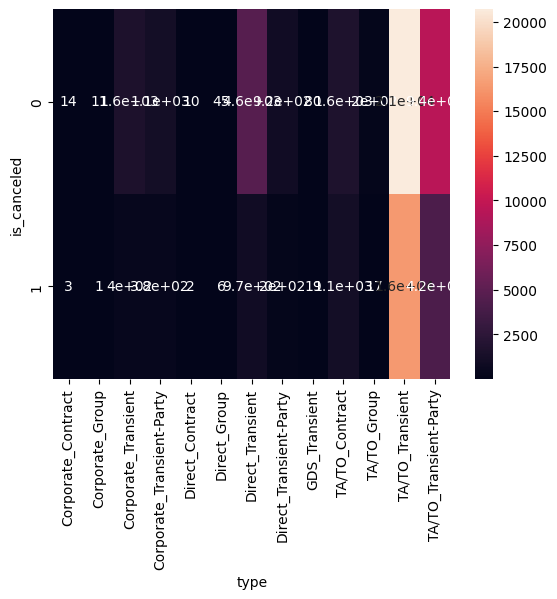

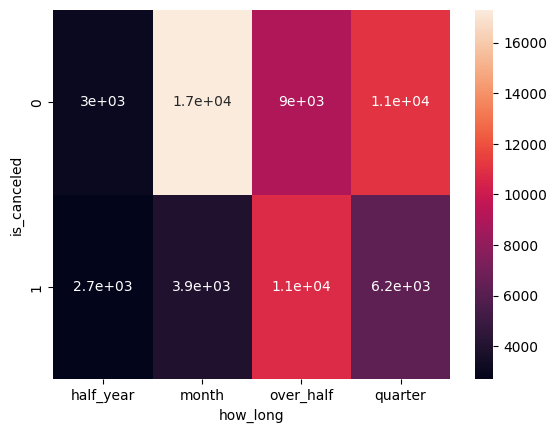

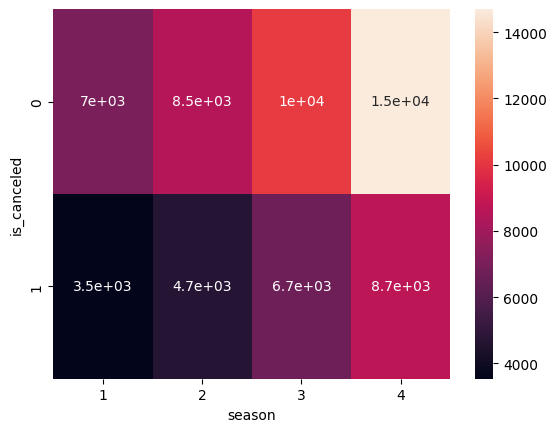

In [39]:
for i in object_columns:
  if i!='country':
    sns.heatmap(df.pivot_table(index='is_canceled',columns=i,values='count_of_people',aggfunc='count'),annot=True)
    plt.show()
    print()
  else:
    df.pivot_table(index='country',columns='is_canceled',values='count_of_people',aggfunc='count').plot(kind='bar',figsize=(18,8))

<Axes: >

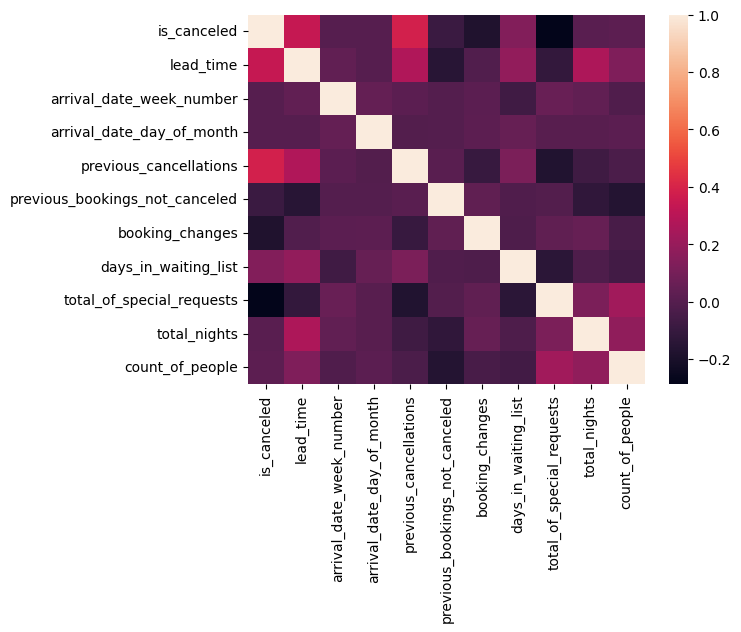

In [40]:
sns.heatmap(df.corr(method='spearman'))

#### Вывод / Conclusion

Были зафиксированны выбросы в числовых признаках,все устранил,так же была построенна матрица кареляции для определения признаков которые могут влиять друг на друга.Мы не видим сильной кореляции между признаками избегая проблема мультиколениарности. / Outliers in numerical features were recorded, everything was eliminated, a karelation matrix was also built to determine the features that can affect each other.We do not see a strong correlation between the signs avoiding the multicolenarity problem.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи / Step 3. Formulation of an ML task based on a business task

#### Расчет прибыли до внедрения депозита / Calculation of profit before the introduction of the deposit

Исходя из входных данных нам необходимо посчитать какую прибыль получал отель до внедрения модели. / Based on the input data, we need to calculate how much profit the hotel received before the implementation of the model.

In [41]:
def profit(df):
  prices={'A':1000,'B':800,'C':600,'D':550,'E':500,'F':450,'G':350}
  loses={'A':400,'B':350,'C':350,'D':150,'E':150,'F':150,'G':150}
  coof={1:1,2:1.2,3:1.4,4:1.2}
  
  if df['is_canceled']==1:
    return ((prices[df['reserved_room_type']]*coof[df['season']])+loses[df['reserved_room_type']])*-1
  elif df['is_canceled']==0:
    return (((prices[df['reserved_room_type']]*coof[df['season']])* df['total_nights'])-(loses[df['reserved_room_type']]*((1 + df['total_nights'] )// 2)))

In [42]:
df['p_l']=df.apply(profit,axis=1)
test['p_l']=test.apply(profit,axis=1)
p_l=df['p_l'].sum()/1000000

In [43]:
print('Прибыль до внедрения составила :',np.round(test['p_l'].sum()/1000000,2),'млн')

Прибыль до внедрения составила : 35.01 млн


### Шаг 4. Разработка модели ML / Step 4. ML Model Development

In [44]:
df.shape

(63978, 24)

In [45]:

features=df.drop(['is_canceled','p_l','arrival_date_year'],axis=1)
target=df['is_canceled']

In [46]:

features_test=test.drop(['is_canceled','p_l','arrival_date_year'],axis=1)
target_test=test['is_canceled']

In [47]:
ohe=['is_repeated_guest','season']
preprocesing=make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),[i for i in features.columns if features[i].dtypes=='object' and i not in ohe]),
                                   (OneHotEncoder(),ohe),
                                   (StandardScaler(),[i for i in features.columns if features[i].dtypes!='object']),remainder='passthrough')


In [48]:
features.shape

(63978, 21)

In [49]:
features_test.shape

(32179, 21)

Функция обучения модели. / Model training function.

In [50]:
def model_study(model,param,features,target):

  pline = Pipeline([('preprocessing', preprocesing),
                    ('model', model)])
    
  rs=RandomizedSearchCV(pline,param,cv=3,random_state=123445,scoring='recall')
  rs.fit(features,target)

  print(rs.best_score_)
  return rs.best_estimator_

В связи с тем что мы видели дисбаланс целевого признака ,нам необходимо использовать метод downsample для того что бы целевой признак был одинаковым / Due to the fact that we have seen an imbalance of the target attribute , we need to use the downsample method in order for the target attribute to be the same

In [51]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [52]:
features_downsampled, target_downsampled = downsample(features, target, 0.6)

In [53]:
target_downsampled.value_counts(normalize=True)

0    0.506219
1    0.493781
Name: is_canceled, dtype: float64

#### Описание/Description

Я выбрал три модели,древо решений ,случайный лес и решил добавить продвинутый алгоритм Catboost. / I chose three models, a decision tree, a random forest and decided to add an advanced Catboost algorithm.

In [54]:
%%time
tree=model_study(DecisionTreeClassifier(random_state=123456),{'model__max_depth':range(2,50),'model__min_samples_leaf':range(2,100,10),'model__min_samples_split':range(2,20,2)},features_downsampled,target_downsampled)

0.8167660241074325
CPU times: user 11.7 s, sys: 50.3 ms, total: 11.7 s
Wall time: 17.8 s


In [55]:
%%time
forest=model_study(RandomForestClassifier(random_state=122344),{'model__max_depth':range(2,50),'model__min_samples_leaf':range(1,100,10),'model__min_samples_split':range(2,20,2),'model__n_estimators':range(1,100)},features_downsampled,target_downsampled)

0.7958089066607871
CPU times: user 32.1 s, sys: 57 ms, total: 32.2 s
Wall time: 32.3 s


In [56]:
%%time
crf=model_study(CatBoostClassifier(random_state=1234345,loss_function='Logloss',verbose=0),{'model__learning_rate':np.arange(0.01,1,0.1),'model__depth':range(2,20),'model__n_estimators':range(100,500,50),'model__reg_lambda':[0.1,1,10]},features_downsampled,target_downsampled)

0.8403896683317309
CPU times: user 9min 16s, sys: 43 s, total: 9min 59s
Wall time: 7min 26s


#### Обновленная функция расчета прибыли. / Updated profit calculation function.

In [57]:
def profit_predict(row):# обновим функцию прибыли исходя из уловий задачи.
    prices = {'A': 1000, 'B': 800, 'C': 600, 'D': 550, 'E': 500, 'F': 450, 'G': 350}
    loses = {'A': 400, 'B': 350, 'C': 350, 'D': 150, 'E': 150, 'F': 150, 'G': 150}
    coof = {1: 1, 2: 1.2, 3: 1.4, 4: 1.2}
    if row['predict'] == 1 and row['is_canceled'] == 1:
        return ((prices[row['reserved_room_type']] * coof[row['season']]) + loses[row['reserved_room_type']]) * -0.2
    elif row['predict'] == 1 and row['is_canceled'] == 0:
        return (((prices[row['reserved_room_type']] * coof[row['season']]) * row['total_nights']) - (loses[row['reserved_room_type']] * ((1 + row['total_nights']) // 2)))
    elif row['predict'] == 0 and row['is_canceled'] == 1:
        return ((prices[row['reserved_room_type']] * coof[row['season']]) + loses[row['reserved_room_type']]) * -1
    elif row['predict'] == 0 and row['is_canceled'] == 0:
        return (((prices[row['reserved_room_type']] * coof[row['season']]) * row['total_nights']) - (loses[row['reserved_room_type']] * ((1 + row['total_nights']) // 2)))
    elif row['predict'] == 2:
        return ((prices[row['reserved_room_type']] * coof[row['season']]) + loses[row['reserved_room_type']]) * -1


#### Информация по моделям после обучения / Information on models after training

In [58]:
def metric_of_profit(data,features,target):# в loses указал потери от клиентов которые отказались от заказа из за депозита
    state = np.random.RandomState(12345)
    loses=[]
    profit=[]
    recall=[]
    for i in data:
        predict=pd.Series(i.predict(features))
        prog=test[['total_nights','reserved_room_type','season','is_canceled']]
        prog['predict']=predict
        bad=prog.loc[(prog['is_canceled']==0)&(prog['predict']==1)]

        bad = bad.sample(len(bad)//2, replace=True, random_state=state)    

        for j in bad.index:
            prog.loc[j,'predict']=2
    
        prog['p_l']=prog.apply(profit_predict,axis=1)
        loses.append(prog.query('predict==2')['p_l'].sum())
        profit.append(prog['p_l'].sum())
        recall.append(cross_val_score(i,features,target,cv=5,scoring='recall').sum()/5)
    profit=pd.DataFrame(profit,columns=['profit'])   
    profit['loses']=pd.Series(loses)
    profit['recall']=pd.Series(recall)
    profit=profit.set_index([['Tree','Forest','Catboost']])
    display(profit)
    profit['recall'].plot(figsize=(5,5),grid=True,color=np.random.rand(7, 3),style='o-');
    return profit[['profit','loses']].plot(kind='bar',figsize=(8,8),grid=True,color=np.random.rand(7, 3));
     

,profit,loses,recall
Tree,25802190.0,-5692220.0,0.817358
Forest,26742896.0,-5010800.0,0.800550
Catboost,26536360.0,-5263010.0,0.846867


<Axes: >

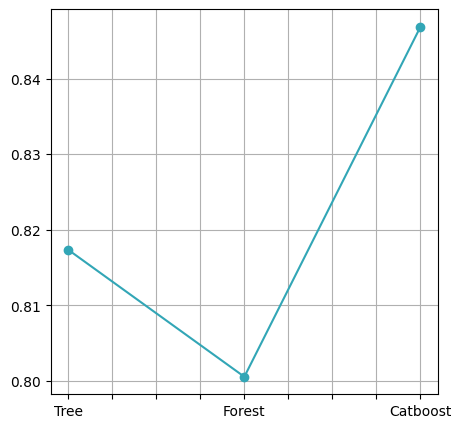

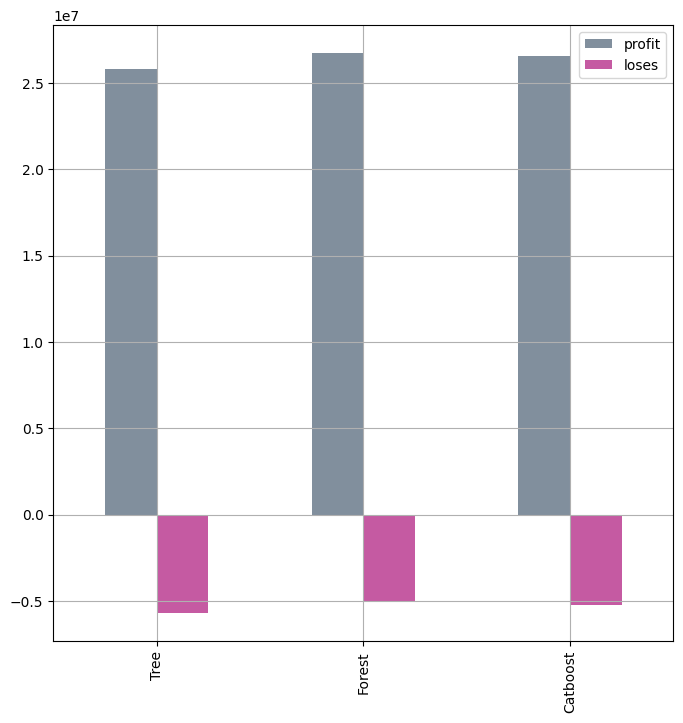

In [59]:
metric_of_profit([tree,forest,crf],features_downsampled, target_downsampled)

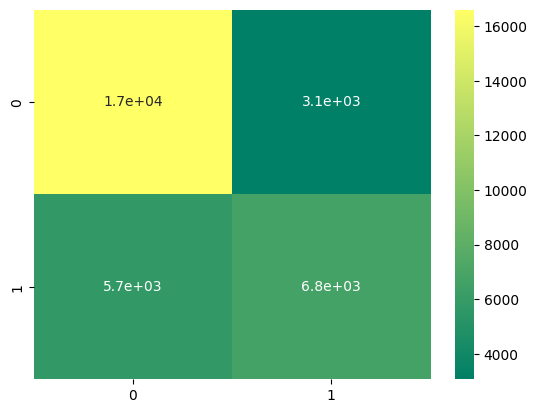

In [60]:
sns.heatmap(data=confusion_matrix(target_test,crf.predict(features_test)),annot=True,cmap= 'summer');

У CatBoost  показатель лучше в связи с этим мы остановимся на этой модели. / CatBoost has a better indicator in this regard, we will focus on this model.

In [61]:
name=pd.Series(crf.predict(features_test))

In [62]:
prog=test[['total_nights','reserved_room_type','season','is_canceled']]

In [63]:
prog['predict']=name
prog['p_l_predict']=prog.apply(profit_predict,axis=1)


In [64]:
print('Прибыль за тестовый период составила / The profit for the test period was:',prog['p_l_predict'].sum())

Прибыль за тестовый период составила / The profit for the test period was: 41849032.0


In [65]:
print('Разница прибыли после внедрения модели / The difference in profit after the implementation of the model ',np.round((prog['p_l_predict'].sum()-test['p_l'].sum()),1))

Разница прибыли после внедрения модели / The difference in profit after the implementation of the model  6839602.0


### Шаг 5. Опишите портрет «ненадёжного» клиента / Step 5. Describe the portrait of an "unreliable" client

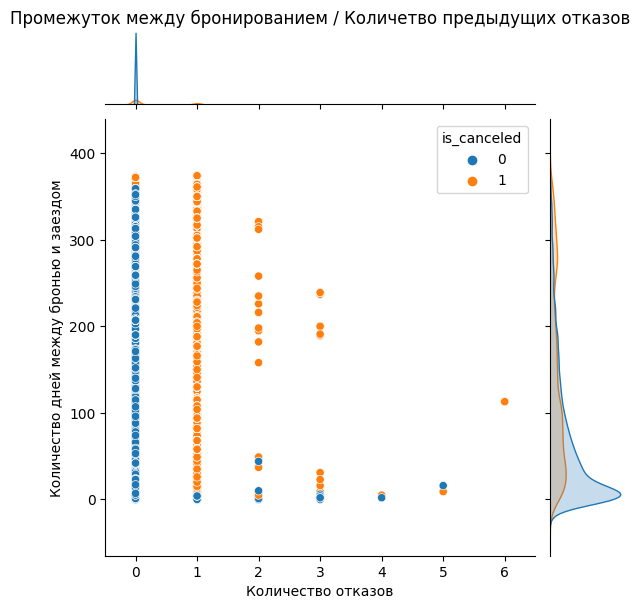

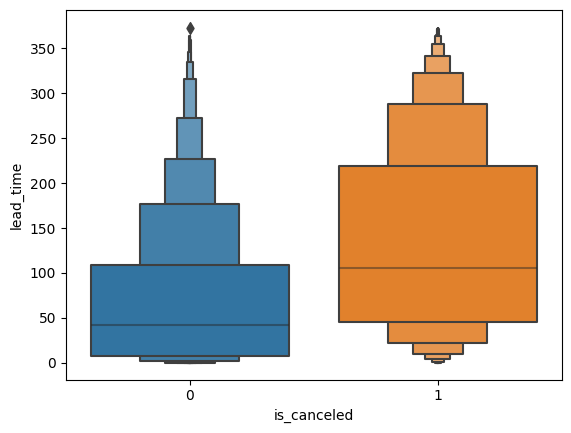

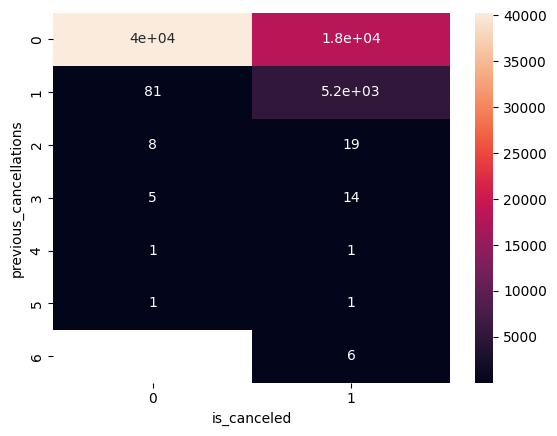

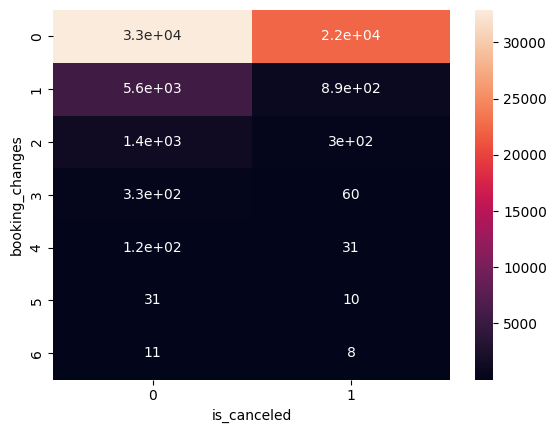

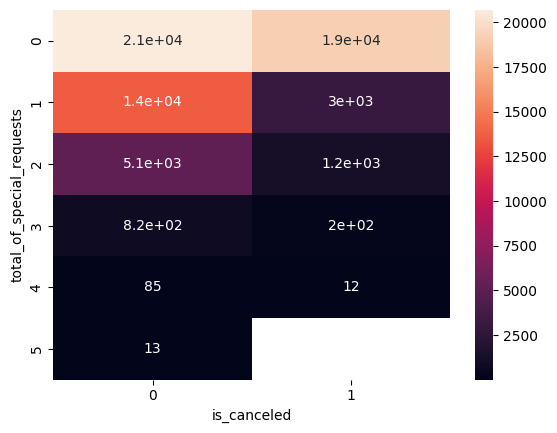

In [66]:
sns.jointplot(x='previous_cancellations',y='lead_time',data=df,hue='is_canceled')
plt.title('Промежуток между бронированием / Количетво предыдущих отказов',y=1.2)
plt.ylabel('Количество дней между бронью и заездом')
plt.xlabel('Количество отказов')
plt.show()
print()
for i in ['lead_time','previous_cancellations','booking_changes','total_of_special_requests']:
  if i=='lead_time':
    sns.boxenplot(x='is_canceled',y=i,data=df)
    plt.show()
  else:
    sns.heatmap(df.pivot_table(index=i,columns='is_canceled',values='p_l',aggfunc='count'),annot=True)
    plt.show()

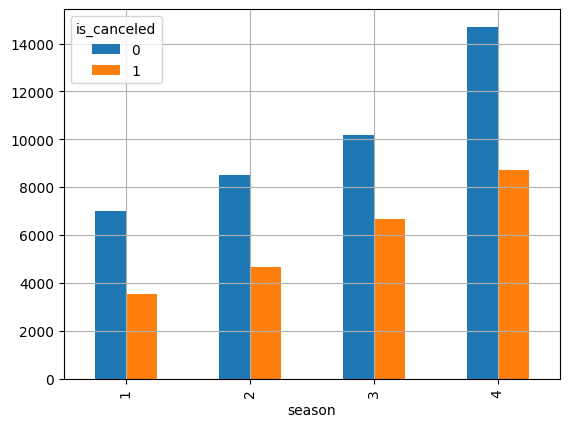

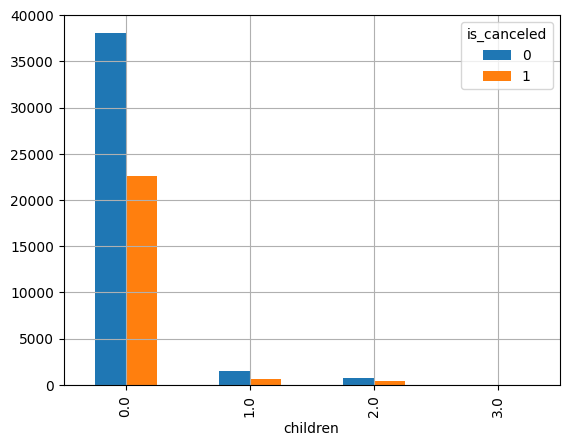

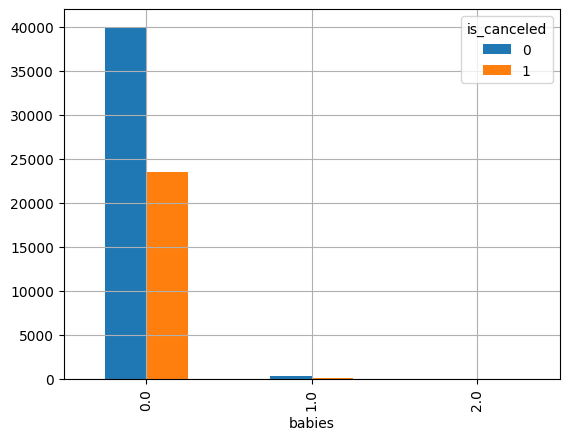

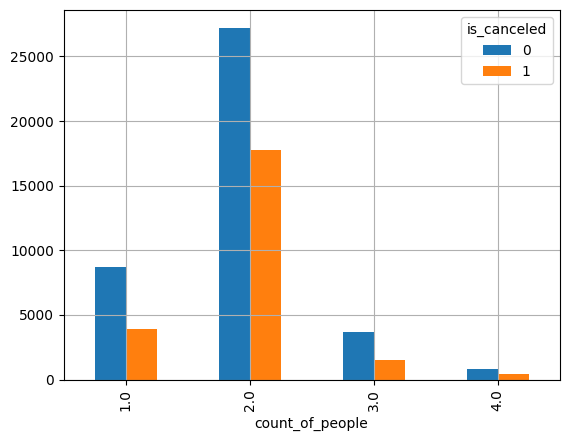

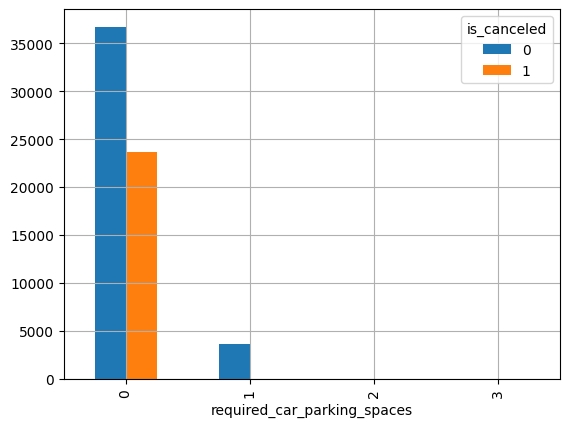

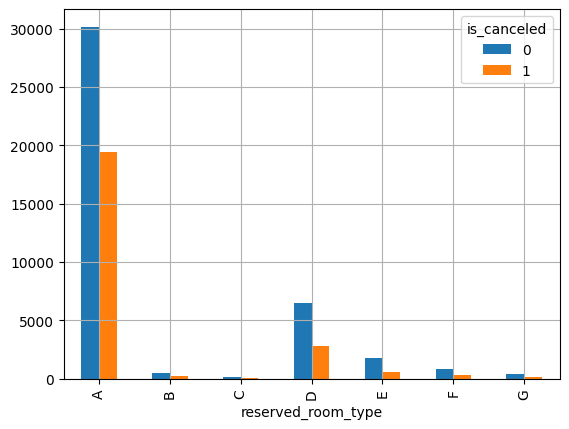

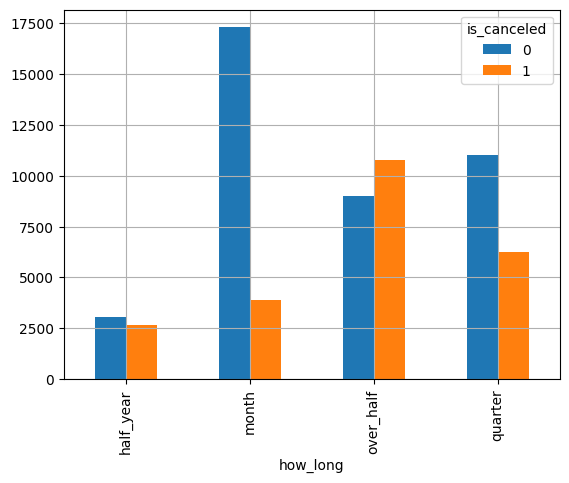

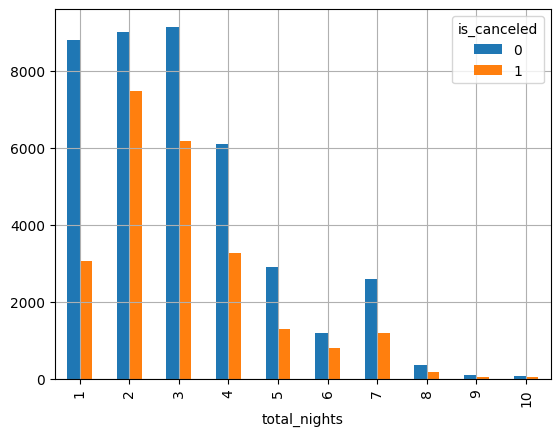

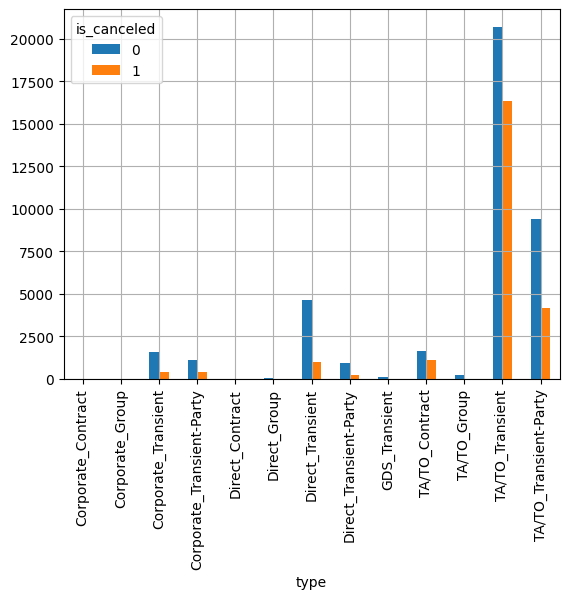

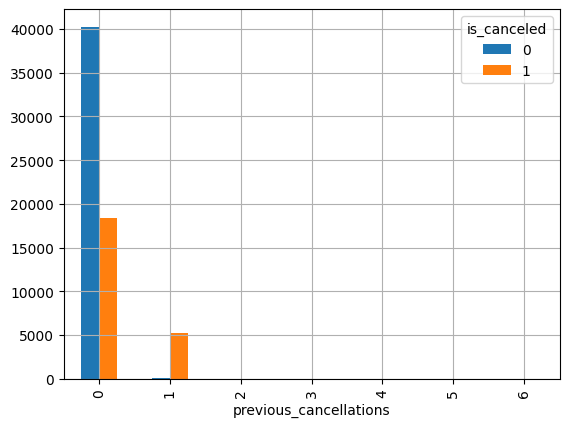

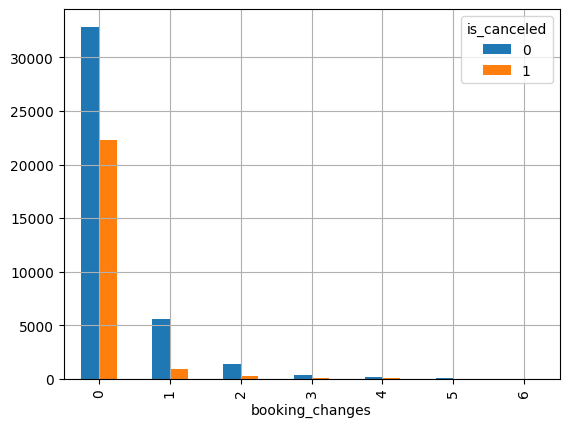

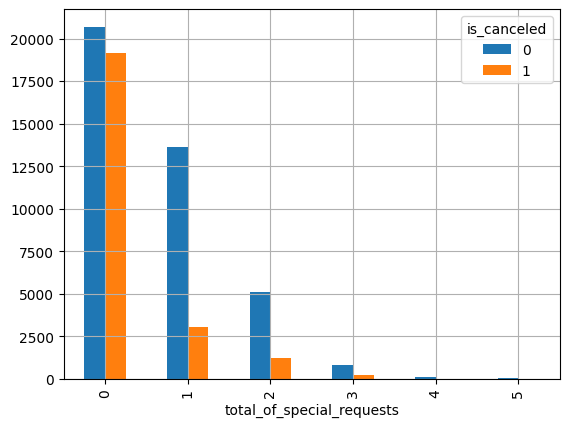

In [67]:

intresting_columns=['season','children','babies','count_of_people','required_car_parking_spaces','reserved_room_type','how_long'
                   ,'total_nights','type','previous_cancellations','booking_changes','total_of_special_requests']
for i in intresting_columns:
    df.pivot_table(index=i,columns='is_canceled',values='p_l',aggfunc='count').plot(kind='bar',grid=True)


Топ стран по отменам своих заказов


<Axes: xlabel='country'>

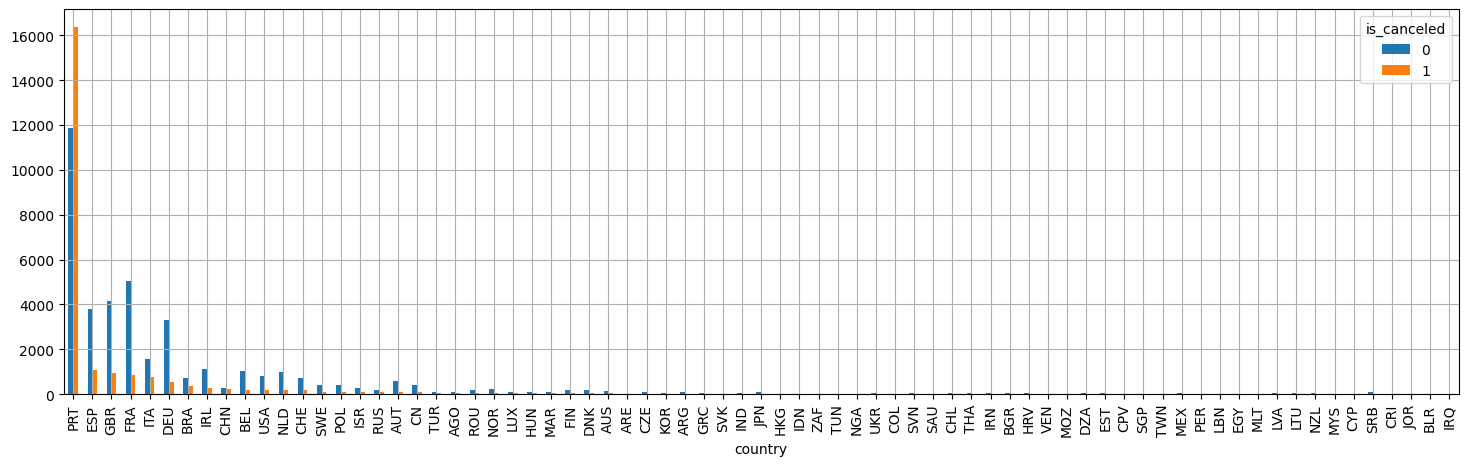

In [68]:
print('Топ стран по отменам своих заказов')
df.pivot_table(index='country',columns='is_canceled',values='p_l',aggfunc='count').sort_values(by=1,ascending=False).plot(kind='bar',figsize=(18,5),grid=True)

In [69]:
coofs=np.round(crf['model'].feature_importances_,3)

preprocessor = crf.named_steps['preprocessing']
oe = preprocessor.transformers_[0][1]  # OrdinalEncoder
ohe = preprocessor.transformers_[1][1]  # OneHotEncoder


ohe_features = ohe.get_feature_names_out()  


oe_features = features.columns[features.dtypes == 'object']

minmax_features = features.columns[features.dtypes != 'object']

all_features = list(oe_features) + list(ohe_features) + list(minmax_features)


col=[i for i in all_features if i not in ['is_repeated_guest','season']]


In [70]:
pd.DataFrame(index=col,data=coofs,columns=['coof']).sort_values(by='coof',ascending=False).head(7)

,coof
country,11.905
arrival_date_day_of_month,11.877
lead_time,11.754
arrival_date_week_number,10.307
total_nights,9.123
total_of_special_requests,7.749
type,7.298


#### Вывод / Conclusion

Выше я провел анализ по признакам ля того что бы выявить портрет ненадежного клиента ,что в итоге мы получили:
*  В первую очередь мы можем увидеть что промежуток между заказом и заездом является сильным признаком обычно люди которые отказываються от брони ,бронируют намного раньше.
*  Также мы можем видеть что жители страны PRT значительно чаще отказываются от брони.
* Так же мы видим что люди которые до этого отменяли бронирование более склонны к этому.
* Так же отдельно модель выделила еще признаки как тип номера и количество специальных запросов.

 ENG: 
 Above , I conducted an analysis on the signs of la in order to identify the portrait of an unreliable client , which in the end we received:
*  First of all, we can see that the gap between the order and arrival is a strong sign, usually people who refuse to book, book much earlier.
*  We can also see that residents of the PRT country are much more likely to refuse reservations.
* We also see that people who have previously canceled reservations are more likely to do this.
* Also separately, the model highlighted other features such as the type of number and the number of special requests.

### Шаг 6. Финальный вывод / Conclusion

Поставленная задача была достигнута,зараты уложиль в бюджет который выделил заказчик,так же мы сразу можем увидеть что такое нововедение модели принесет прибыль компании в первом же году.Так же из анализа мы выявили определеннные признаки на которые необходимо обратить внимание что бы сократить пррцент отказов. / The task was achieved, the money was put into the budget that the customer allocated, so we can immediately see that such a new model will bring profit to the company in the first year.Also, from the analysis, we have identified certain signs that need to be paid attention to in order to reduce the percentage of failures.